# import modules

In [1]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver1 import *
from modules.default_params_ver1 import *
from modules.functions_ver1_draft import *

plt.rcParams["figure.dpi"] = 150

# # after making changes to scripts, reload them
# import importlib

# import scripts.Classes_ver1
# importlib.reload(scripts.Classes_ver1)
# from scripts.Classes_ver1 import *

# import scripts.default_params_ver1
# importlib.reload(scripts.default_params_ver1)
# from scripts.default_params_ver1 import *

# import scripts.functions_ver1
# importlib.reload(scripts.functions_ver1)
# from scripts.functions_ver1 import *

# assign params

default: mcz = 20 solar masses, MLz = 2000 solar masses

In [2]:
lens_params, RP_params = set_to_params(lens_params_1, RP_params_1)

# define plotting functions

In [3]:
def mismatch_contour(
    t_params, s_params, lens_Class=LensingGeo, prec_Class=Precessing, opt_match=True
):
    n_pts = 60
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    Z = np.zeros_like(X)
    g_min_matrix = np.zeros_like(X)

    for r in range(n_pts):
        for c in range(n_pts):
            t_params["omega_tilde"] = X[r, c]
            t_params["theta_tilde"] = Y[r, c]

            results = optimize_mismatch_gammaP_general(
                t_params, s_params, lens_Class, prec_Class, opt_match
            )

            Z[r, c] = results["ep_min"]
            g_min_matrix[r, c] = results["ep_min_gamma"]

    # print mismatch at the bottom left corner
    print("mismatch at bottom left corner = {:.3g}".format(Z[0, 0]))

    # print coordinates where mismatch is min
    min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
    print("min mismatch = {:.3g}".format(Z[min_idx]))
    print("min omega_tilde = {:.3g}".format(X[min_idx]))
    print("min theta_tilde = {:.3g}".format(Y[min_idx]))
    print("min gamma_P = {:.3g}".format(g_min_matrix[min_idx]))

    # print coordinates where mismatch is max
    max_idx = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    print("max mismatch = {:.3g}".format(Z[max_idx]))
    print("max omega_tilde = {:.3g}".format(X[max_idx]))
    print("max theta_tilde = {:.3g}".format(Y[max_idx]))
    print("max gamma_P = {:.3g}".format(g_min_matrix[max_idx]))

    # print ratio of max to min mismatch
    print("max/min mismatch = {:.3g}".format(Z[max_idx] / Z[min_idx]))

    plt.contourf(X, Y, Z, levels=60, cmap="jet")
    plt.xlabel(r"$\tilde{\Omega}$", fontsize=14)
    plt.ylabel(r"$\tilde{\theta}$", fontsize=14)

    plt.colorbar(cmap="jet", norm=colors.Normalize(vmin=0, vmax=1)).set_label(
        label=r"$\epsilon(\~h_{\rm P}, \~h_{\rm L})$", size=14
    )
    plt.suptitle(
        "Mismatch Between RP Templates and a Lensed Source",
        fontsize=16,
        y=1.0215,
        x=0.435,
    )

    # get lensing parameters
    lens_inst = lens_Class(s_params)
    Delta_td = lens_inst.Delta_td()
    I = lens_inst.I()

    plt.title(
        r"$\theta_S$ = {}, $\phi_S$ = {}, $\theta_J$ = {}, $\phi_J$ = {}, $\Delta t_d$ = {:.2g} ms, $I$ = {:.2g}, {} = {:.3g} {}".format(
            r"$\pi/2$",
            r"$\pi/4$",
            r"$\pi/6$",
            r"$\pi/3$",
            Delta_td * 1e3,
            I,
            r"$\mathcal{M}_{\rm s}$",
            s_params["mcz"] / solar_mass,
            r"$M_{\odot}$",
        ),
        fontsize=12,
        y=1.021,
    )
    plt.show()

In [4]:
import os

cpu_count = os.cpu_count()
print("Number of CPUs in the system:", cpu_count)

Number of CPUs in the system: 8


In [5]:
from multiprocessing import Pool


def compute_mismatch(r, c, t_params, s_params, lens_Class, prec_Class, opt_match):
    n_pts = 60
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    t_params["omega_tilde"] = X[r, c]
    t_params["theta_tilde"] = Y[r, c]

    results = optimize_mismatch_gammaP_general(
        t_params, s_params, lens_Class, prec_Class, opt_match
    )

    return (results["ep_min"], results["ep_min_gamma"])


def mismatch_contour_parallel(
    t_params, s_params, lens_Class=LensingGeo, prec_Class=Precessing, opt_match=True
):
    n_pts = 60
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    Z = np.zeros_like(X)
    g_min_matrix = np.zeros_like(X)

    # Create a pool of worker processes
    with Pool() as pool:
        results = []
        for r in range(n_pts):
            for c in range(n_pts):
                results.append(
                    pool.apply_async(
                        compute_mismatch,
                        args=(
                            r,
                            c,
                            t_params,
                            s_params,
                            lens_Class,
                            prec_Class,
                            opt_match,
                        ),
                    )
                )

        for r in range(n_pts):
            for c in range(n_pts):
                idx = r * n_pts + c
                Z[r, c], g_min_matrix[r, c] = results[idx].get()

    # print mismatch at the bottom left corner
    print("mismatch at bottom left corner = {:.3g}".format(Z[0, 0]))

    # print coordinates where mismatch is min
    min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
    print("min mismatch = {:.3g}".format(Z[min_idx]))
    print("min omega_tilde = {:.3g}".format(X[min_idx]))
    print("min theta_tilde = {:.3g}".format(Y[min_idx]))
    print("min gamma_P = {:.3g}".format(g_min_matrix[min_idx]))

    # print coordinates where mismatch is max
    max_idx = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    print("max mismatch = {:.3g}".format(Z[max_idx]))
    print("max omega_tilde = {:.3g}".format(X[max_idx]))
    print("max theta_tilde = {:.3g}".format(Y[max_idx]))
    print("max gamma_P = {:.3g}".format(g_min_matrix[max_idx]))

    # print ratio of max to min mismatch
    print("max/min mismatch = {:.3g}".format(Z[max_idx] / Z[min_idx]))

    plt.contourf(X, Y, Z, levels=60, cmap="jet")
    plt.xlabel(r"$\tilde{\Omega}$", fontsize=14)
    plt.ylabel(r"$\tilde{\theta}$", fontsize=14)

    plt.colorbar(cmap="jet", norm=colors.Normalize(vmin=0, vmax=1)).set_label(
        label=r"$\epsilon(\~h_{\rm P}, \~h_{\rm L})$", size=14
    )
    plt.suptitle(
        "Mismatch Between RP Templates and a Lensed Source",
        fontsize=16,
        y=1.0215,
        x=0.435,
    )

    # get lensing parameters
    lens_inst = lens_Class(s_params)
    Delta_td = lens_inst.Delta_td()
    I = lens_inst.I()

    plt.title(
        r"$\theta_S$ = {}, $\phi_S$ = {}, $\theta_J$ = {}, $\phi_J$ = {}, $\Delta t_d$ = {:.2g} ms, $I$ = {:.2g}, {} = {:.3g} {}".format(
            r"$\pi/2$",
            r"$\pi/4$",
            r"$\pi/6$",
            r"$\pi/3$",
            Delta_td * 1e3,
            I,
            r"$\mathcal{M}_{\rm s}$",
            s_params["mcz"] / solar_mass,
            r"$M_{\odot}$",
        ),
        fontsize=12,
        y=1.021,
    )
    plt.show()

# mismatch between RP & L with L fixed

mismatch at bottom left corner = 0.222
min mismatch = 0.0451
min omega_tilde = 2.15
min theta_tilde = 8
min gamma_P = 5.2
max mismatch = 0.222
max omega_tilde = 0
max theta_tilde = 0
max gamma_P = 0


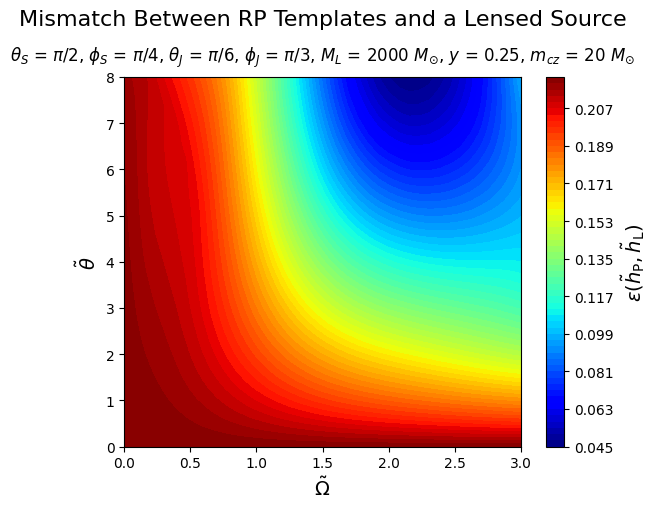

In [5]:
lens_params, RP_params = set_to_params(lens_params_1, RP_params_1)

mismatch_contour(RP_params, lens_params)

mismatch at bottom left corner = 0.222
min mismatch = 0.0452
min omega_tilde = 2.14
min theta_tilde = 8
min gamma_P = 5.27
max mismatch = 0.222
max omega_tilde = 0
max theta_tilde = 0
max gamma_P = 0
max/min mismatch = 4.91


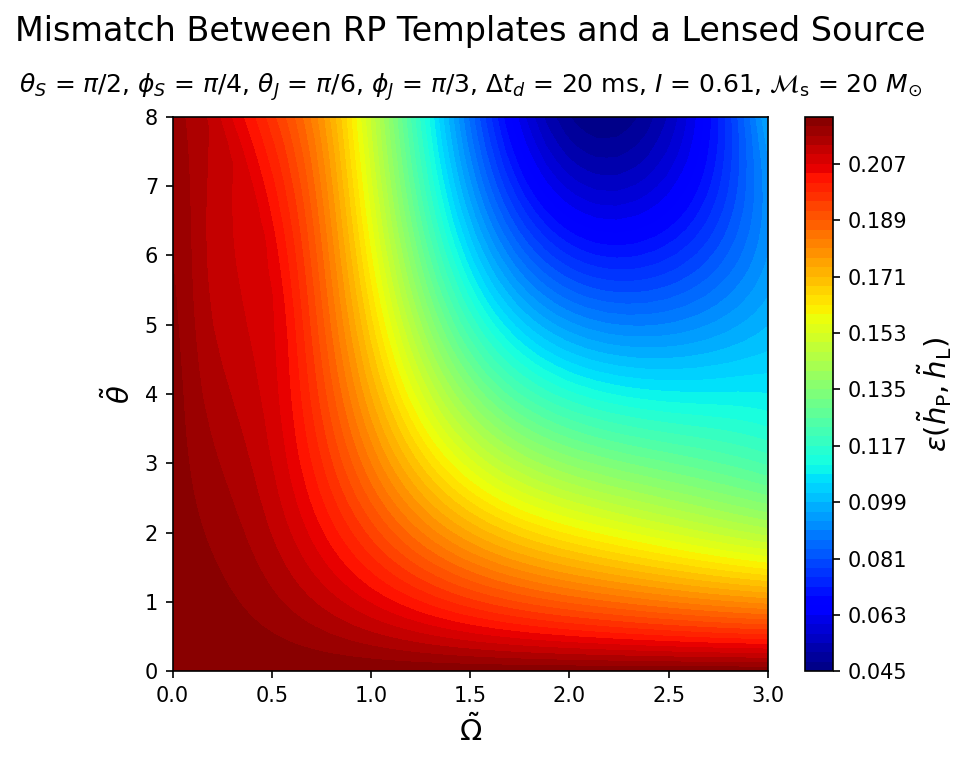

In [6]:
# 2024-06-06

lens_params, RP_params = set_to_params(lens_params_1, RP_params_1)

mismatch_contour_parallel(RP_params, lens_params)

mismatch at bottom left corner = 0.175
min mismatch = 0.00289
min omega_tilde = 1.78
min theta_tilde = 5.83
min gamma_P = 2.79
max mismatch = 0.175
max omega_tilde = 0
max theta_tilde = 0
max gamma_P = 0
max/min mismatch = 60.4


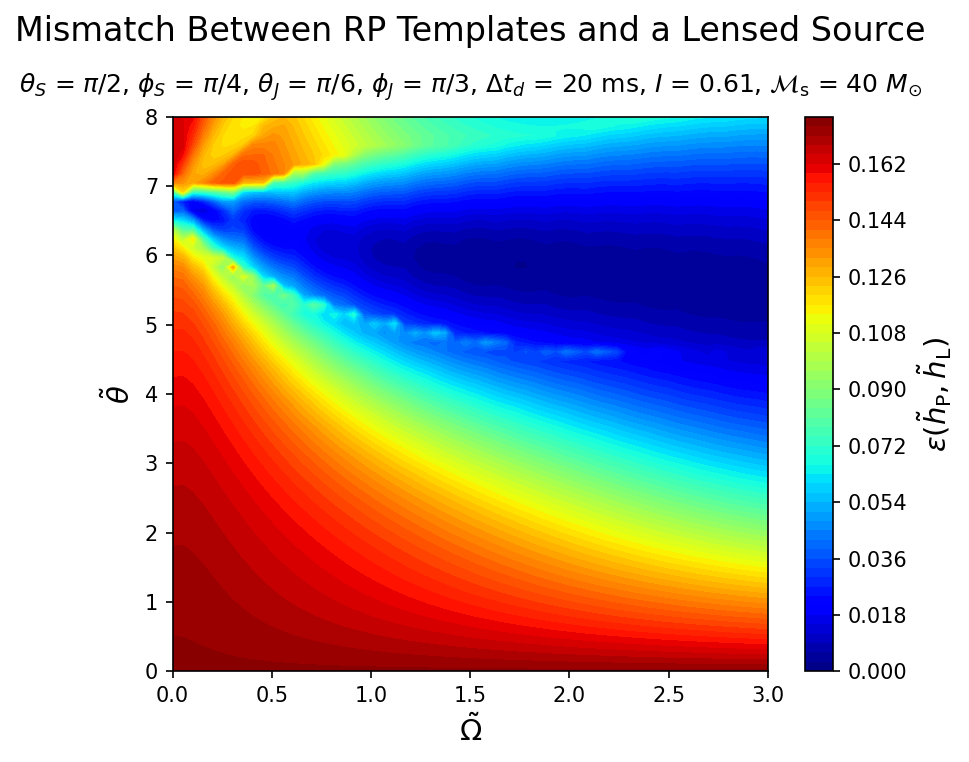

In [7]:
# 2024-06-06

lens_params, RP_params = set_to_params(lens_params_1, RP_params_1)

lens_params["mcz"] = RP_params["mcz"] = 40 * solar_mass

mismatch_contour_parallel(RP_params, lens_params)

mismatch at bottom left corner = 0.151
min mismatch = 0.00344
min omega_tilde = 2.54
min theta_tilde = 5.95
min gamma_P = 1.08
max mismatch = 0.151
max omega_tilde = 0
max theta_tilde = 0
max gamma_P = 0
max/min mismatch = 43.7


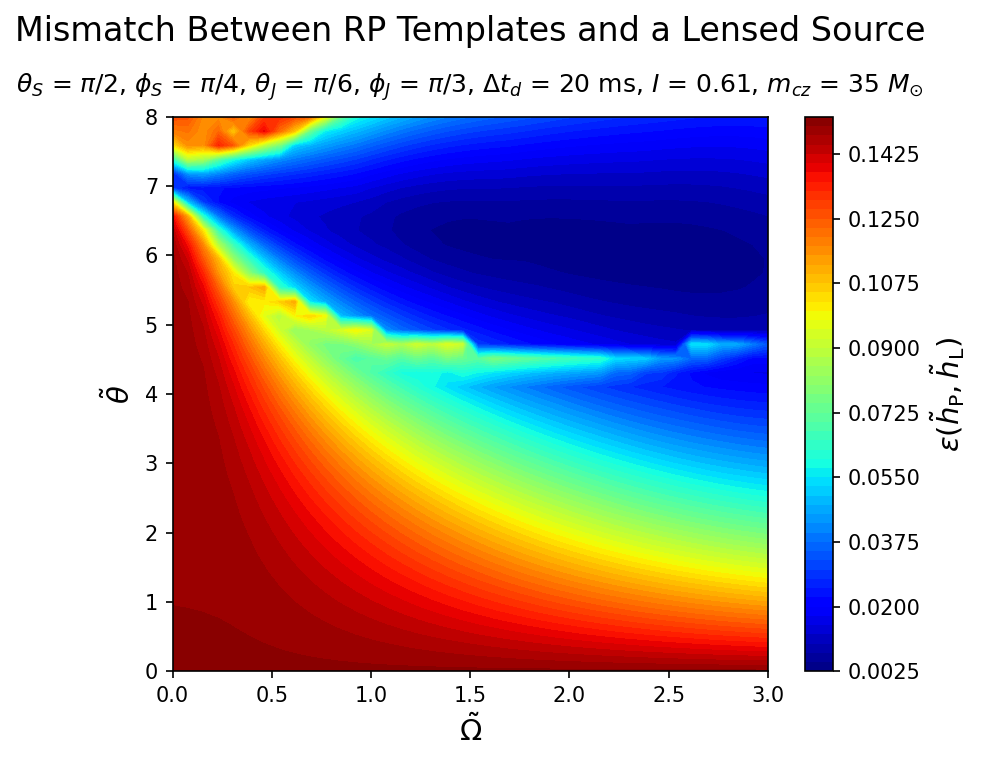

In [32]:
lens_params, RP_params = set_to_params(lens_params_1, RP_params_1)

lens_params["mcz"] = RP_params["mcz"] = 35 * solar_mass

mismatch_contour_parallel(RP_params, lens_params)

mismatch at bottom left corner = 0.165
min mismatch = 0.0031
min omega_tilde = 1.62
min theta_tilde = 6.77
min gamma_P = 2.22
max mismatch = 0.165
max omega_tilde = 0
max theta_tilde = 0
max gamma_P = 0
max/min mismatch = 53.3


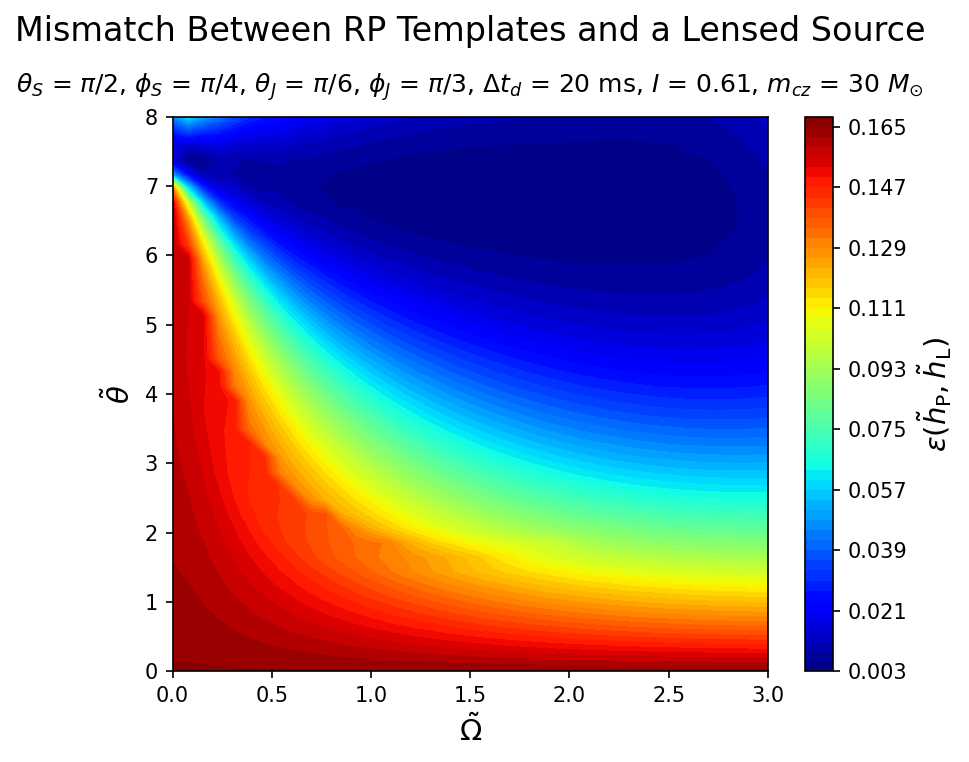

In [33]:
lens_params, RP_params = set_to_params(lens_params_1, RP_params_1)

lens_params["mcz"] = RP_params["mcz"] = 30 * solar_mass

mismatch_contour_parallel(RP_params, lens_params)

mismatch at bottom left corner = 0.0246
min mismatch = 2.07e-05
min omega_tilde = 1.54
min theta_tilde = 4.92
min gamma_P = 3.81
max mismatch = 0.0246
max omega_tilde = 0
max theta_tilde = 0
max gamma_P = 0
max/min mismatch = 1.19e+03


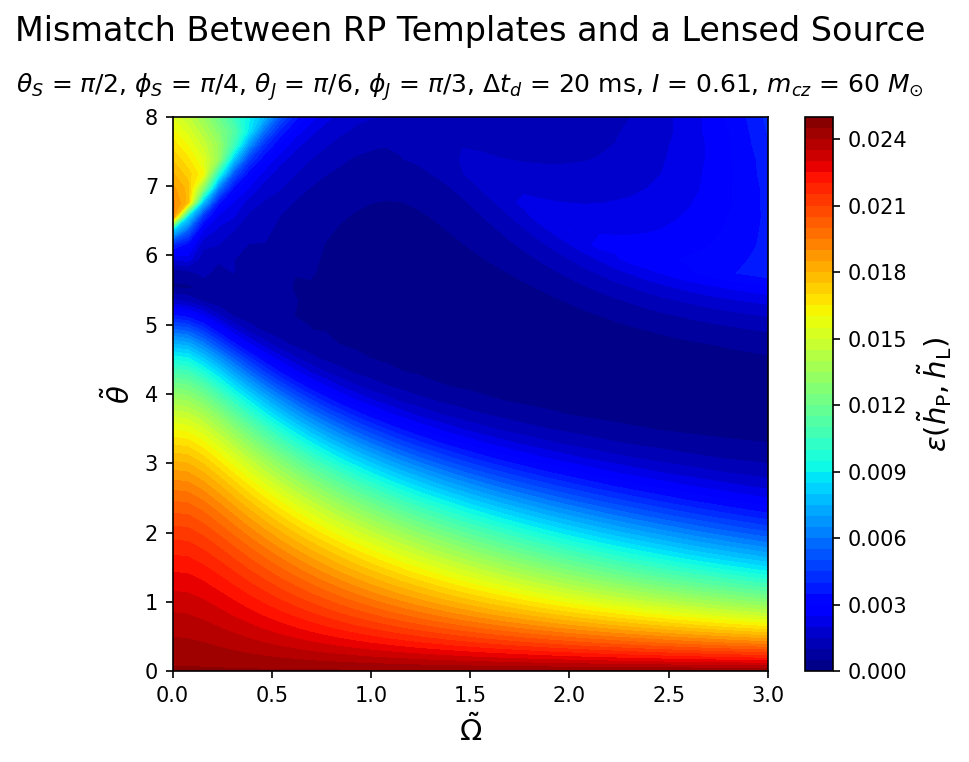

In [34]:
lens_params, RP_params = set_to_params(lens_params_1, RP_params_1)

lens_params["mcz"] = RP_params["mcz"] = 60 * solar_mass

mismatch_contour_parallel(RP_params, lens_params)